Follows $\texttt{https://github.com/ericmetodiev/OmniFold/blob/master/OmniFold\%20Demo.ipynb}$ but uses pip-installable version of OmniFold

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import energyflow as ef # for data
import omnifold # for omnifold algorithm

# Local imports for plotting (source: https://github.com/ericmetodiev/OmniFold/blob/master/modplot.py)
import modplot
from plot_utils import *

plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

# Global variables
OBS_MULTIFOLD = ['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass']
N_DATA = int(1e6)
N_ITER = 10
BATCH_SIZE = 500
EPOCHS = 10
N_JOBS = 16


2025-03-23 16:46:25.718781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742773585.735572  736131 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742773585.740651  736131 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742773585.755634  736131 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742773585.755651  736131 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742773585.755653  736131 computation_placer.cc:177] computation placer alr

Horovod not found, will continue with single only GPUs.


# Load data

We assume, for simplicity:
1. That everything passes the reco and gen cuts
2. That the data is already normalized
3. That the data is uniformly weighted, to begin

We choose Pythia as the Monte Carlo data

In [2]:
data_mc_dict = ef.zjets_delphes.load('Pythia26', num_data=N_DATA, exclude_keys=['particles'])
data_mc_gen = {k.replace("gen_", ""): data_mc_dict[k] for k in data_mc_dict.keys() if 'gen_' in k}
data_mc_sim= {k.replace("sim_", ""): data_mc_dict[k] for k in data_mc_dict.keys() if 'sim_' in k}

data_mc_gen['Mass'] = data_mc_gen['jets'][:,3]
data_mc_gen.pop('jets')
data_mc_gen['Mult'] = data_mc_gen.pop('mults')
data_mc_gen['Width'] = data_mc_gen.pop('widths')
data_mc_gen['Tau21'] = data_mc_gen.pop('tau2s')
data_mc_gen['zg'] = data_mc_gen.pop('zgs')
data_mc_gen['SDMass'] = data_mc_gen.pop('sdms')
data_mc_gen = np.concatenate([data_mc_gen[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

data_mc_sim['Mass'] = data_mc_sim['jets'][:,3]
data_mc_sim.pop('jets')
data_mc_sim['Mult'] = data_mc_sim.pop('mults')
data_mc_sim['Width'] = data_mc_sim.pop('widths')
data_mc_sim['Tau21'] = data_mc_sim.pop('tau2s')
data_mc_sim['zg'] = data_mc_sim.pop('zgs')
data_mc_sim['SDMass'] = data_mc_sim.pop('sdms')
data_mc_sim = np.concatenate([data_mc_sim[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

# Create DataLoader object
data_mc = omnifold.DataLoader(reco=data_mc_sim, gen=data_mc_gen)


INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...


And Hedwig as the true/nature data

In [3]:
data_nature_dict = ef.zjets_delphes.load('Herwig', num_data=N_DATA, exclude_keys=['particles'])
data_nature_gen = {k.replace("gen_", ""): data_nature_dict[k] for k in data_nature_dict.keys() if 'gen_' in k}
data_nature_sim= {k.replace("sim_", ""): data_nature_dict[k] for k in data_nature_dict.keys() if 'sim_' in k}

data_nature_gen['Mass'] = data_nature_gen['jets'][:,3]
data_nature_gen.pop('jets')
data_nature_gen['Mult'] = data_nature_gen.pop('mults')
data_nature_gen['Width'] = data_nature_gen.pop('widths')
data_nature_gen['Tau21'] = data_nature_gen.pop('tau2s')
data_nature_gen['zg'] = data_nature_gen.pop('zgs')
data_nature_gen['SDMass'] = data_nature_gen.pop('sdms')
data_nature_gen = np.concatenate([data_nature_gen[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

data_nature_sim['Mass'] = data_nature_sim['jets'][:,3]
data_nature_sim.pop('jets')
data_nature_sim['Mult'] = data_nature_sim.pop('mults')
data_nature_sim['Width'] = data_nature_sim.pop('widths')
data_nature_sim['Tau21'] = data_nature_sim.pop('tau2s')
data_nature_sim['zg'] = data_nature_sim.pop('zgs')
data_nature_sim['SDMass'] = data_nature_sim.pop('sdms')
data_nature_sim = np.concatenate([data_nature_sim[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

# Create DataLoader object
data_nature = omnifold.DataLoader(reco=data_nature_sim, gen=data_nature_gen)


INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...


# Construct MultiFold object

In [4]:
name = "MultiFold"
model_reco = omnifold.net.MLP(nvars = len(OBS_MULTIFOLD))
model_gen = omnifold.net.MLP(nvars = len(OBS_MULTIFOLD))
data = data_nature
mc = data_mc
model = omnifold.MultiFold(
    name=name, 
    model_reco=model_reco, 
    model_gen=model_gen, 
    data=data, 
    mc=mc, 
    niter=N_ITER,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    size=N_JOBS)

# Keep track of original weights
mc_w_init = model.mc.weight.copy()
data_w_init = model.data.weight.copy()

I0000 00:00:1742773592.951719  736131 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 888 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


250 training steps at reco and 250 steps at gen


# Unfold

In [5]:
model.Unfold()

ITERATION: 1
RUNNING STEP 1


I0000 00:00:1742773595.416300  737095 service.cc:152] XLA service 0x7fd8e00059c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742773595.416333  737095 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2025-03-23 16:46:35.441649: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742773595.609990  737095 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742773596.208424  737095 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Last val loss 0.6802902817726135
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 0.6961603760719299
INFO: Dumping training history ...
ITERATION: 2
RUNNING STEP 1
Last val loss 0.7029992938041687
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 0.6758874654769897
INFO: Dumping training history ...
ITERATION: 3
RUNNING STEP 1
Last val loss 0.6898609399795532
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 0.6951307654380798
INFO: Dumping training history ...
ITERATION: 4
RUNNING STEP 1
Last val loss 0.6952818632125854
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 0.6740889549255371
INFO: Dumping training history ...
ITERATION: 5
RUNNING STEP 1
Last val loss 0.6793612837791443
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 0.678454577922821
INFO: Dumping training history ...
ITERATION: 6
RUNNING STEP 1
Last val loss 0.6968636512756348
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 0.6808276

# Evaluate

e.g. Mass

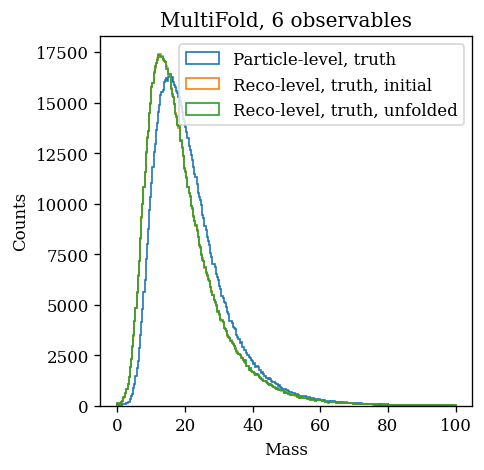

In [ ]:
mass_bins = np.linspace(0, 100, 300)

plt.figure()
plt.hist(data_nature_gen[:,0], bins=mass_bins, weights=model.data.weight, histtype='step', label='Particle-level, truth')
plt.hist(data_nature_sim[:,0], bins=mass_bins, weights=model.mc.weight, histtype='step', label='Reco-level, truth, initial')
plt.hist(data_nature_sim[:,0], bins=mass_bins, weights=model.weights_push, histtype='step', label='Reco-level, truth, unfolded')
# plt.fill_between(data_mc_sim[:,0], bins=mass_bins, weights=model.weights_push, label='Reco-level, sim, unfolded')
plt.title("MultiFold, 6 observables")
plt.xlabel('Mass')
plt.ylabel('Counts')
plt.legend()